## Hollow conductor with multiple dielectrics

In [17]:
# Direct SOR solver
using Plots

struct V
    id::Int
end

M =
[100  100   100   0    100  100  100;         # e1
 0    V(1)  100   0    100  V(9)  0;          # e1
 0    V(2)  100   100  100  V(8)  0;          # e2, i = 3
 0    V(3)  V(4)  V(5) V(6) V(7)  0;          # e2
 0    0     0     0    0    0     0;];        # e2

e0 = 8.85418782e-12

e_r1 = e0

e_r2 = 9.6*e0

e_av = (e_r1 + e_r2)/2

# Initialize result
Φ = map(x -> x isa Number ? Float64(x) : 0, M)

# Get node coordinates
nodes = Vector{Tuple}()
for I in CartesianIndices(M)
    i,j = Tuple(I)
    v = M[i, j]
    if typeof(v) == V
        push!(nodes, Tuple(I))
    end
    #println(M[i,j])
end


for n in range(1,1000) 
    R = 0;
    # Iterate over nodes
    for (i, j) in nodes
        # Handle e1 to e2 interface
        if i == 3
            R = (1/(4*e_av))*( e_r1*Φ[i-1,j] + e_r2*Φ[i+1,j] + e_av*Φ[i,j-1] + e_av*Φ[i,j+1] -4*e_av*Φ[i,j] )
        # Handle constant e
        else
            R = ( Φ[i+1,j] + Φ[i-1,j] + Φ[i,j+1] + Φ[i,j-1] - 4*Φ[i,j] )/4
        end

        Φ[i,j] = Φ[i,j] + R
    end

    #println(R) 
    if R < 0.000001 
        break
    end

end

println(repr("text/plain", Φ))

5×7 Matrix{Real}:
 100.0  100.0     100.0       0.0     100.0     100.0     100.0
   0.0   59.1518  100.0       0.0     100.0      59.1518    0.0
   0.0   36.6073  100.0     100.0     100.0      36.6073    0.0
   0.0   19.4712   41.2775   45.6387   41.2775   19.4712    0.0
   0.0    0.0       0.0       0.0       0.0       0.0       0.0


## Microstrip

In [38]:
const tolerance = 0.0001

# Direct SOR solver
using Plots

"""
    for_rectangle_boundary(f::Function, top_left::Tuple{Int,Int}, bottom_right::Tuple{Int,Int})

Applies function `f(i,j,ni,nj)` to each point along the boundary of a rectangle
defined by `top_left = (i1,j1)` and `bottom_right = (i2,j2)`, clockwise.

`(ni,nj)` is the outward normal vector at that point:
- Top edge: (-1,0)
- Right edge: (0,1)
- Bottom edge: (1,0)
- Left edge: (0,-1)
"""
function for_rectangle_boundary(f::Function, top_left::Tuple{Int,Int}, bottom_right::Tuple{Int,Int})
    i1, j1 = top_left
    i2, j2 = bottom_right

    # Top edge (left → right), normal points up
    for j in j1:j2
        f(i1, j, -1, 0)
    end

    # Right edge (top → bottom), normal points right
    for i in i1+1:i2
        f(i, j2, 0, 1)
    end

    # Bottom edge (right → left), normal points down
    for j in j2-1:-1:j1
        f(i2, j, 1, 0)
    end

    # Left edge (bottom → top), normal points left
    for i in i2-1:-1:i1+1
        f(i, j1, 0, -1)
    end
end

# Node representing an unknown voltage
struct V
    id::Int
end

function build_microstrip_model(h::AbstractFloat, dielectric_thickness::Int, width_units::Int, voltage::AbstractFloat)

    ms_width = width_units
    ms_height = dielectric_thickness

    spacer_y = width_units*6
    spacer_x = width_units*3

    M = Matrix{Any}(undef,ms_height + 2 + spacer_y + 2,  (ms_width + 1) + spacer_x*2 )

    idx = 1
    for i in 1:size(M,1)
        for j in 1:size(M,2)
            if (i == 1) || (i == size(M,1)) || (j == 1) || (j == size(M,2) ) 
                M[i,j] = 0;
            else
                M[i,j] = V(idx)
                idx += 1
            end
        end
    end

    # Build microstrip
    for j in range(Int(floor(size(M,2)/2)) - Int(ms_width/2), Int(floor(size(M,2)/2)) + Int(ms_width/2)) 
        M[size(M,1) - 1 - ms_height,j+1] = voltage
        M[size(M,1) - 2 - ms_height,j+1] = voltage
    end

    return M
end

function solve_model_potentials(M::Matrix, e_r1::AbstractFloat, e_r2::AbstractFloat, ms_height::Int)
    # Initialize result
    Φ = map(x -> x isa Number ? Float64(x) : 0, M)

    # Get node coordinates
    nodes = Vector{Tuple}()
    for I in CartesianIndices(M)
        i,j = Tuple(I)
        v = M[i, j]
        if typeof(v) == V
            push!(nodes, Tuple(I))
        end
        #println(M[i,j])
    end

    for n in range(1,1000) 
        Rmax = 0.0
        R = 0;
        # Iterate over nodes
        for (i, j) in nodes
            # Handle e1 to e2 interface
            if i == size(M,1) - ms_height
                R = (1/(4*e_av))*( e_r1*Φ[i-1,j] + e_r2*Φ[i+1,j] + e_av*Φ[i,j-1] + e_av*Φ[i,j+1] -4*e_av*Φ[i,j] )
            # Handle constant e
            else
                R = ( Φ[i+1,j] + Φ[i-1,j] + Φ[i,j+1] + Φ[i,j-1] - 4*Φ[i,j] )/4
            end

            Φ[i,j] = Φ[i,j] + R

            Rmax = max(Rmax, abs(R))
        end
        
        #println(R) 
        if Rmax < tolerance 
            break
        end

    end

    return Φ
end

function calculate_Q(Φ::Matrix, (y1,x1)::Tuple{Int, Int}, (y2, x2)::Tuple{Int, Int}, e_r1::AbstractFloat, e_r2::AbstractFloat, ms_height::Int)
    # Calculate charge on the microstrip
    Q = 0
    for_rectangle_boundary((y1,x1), (y2, x2)) do i, j, ni, nj      
        e = e_r1
        
        if i == size(Φ,1) - ms_height
            e = e_av
        end
        
        if i > size(Φ,1) - ms_height
            e = e_r2
        end

        Q -= e*(Φ[i+ni,j+nj] - Φ[i,j])/1
        #println("Boundary point: i=$i, $ni, j=$j, $nj, Φ=$(Φ[i,j]), Q=$Q")
    end

    return Q
end

h = 0.0001 # Cell size is 0.1 mm

ms_V = 1.0
ms_width = 20 # 1/10 = 2 mm
ms_height = 10 # 1/10 = 1 mm

M = build_microstrip_model(h, ms_height, ms_width, ms_V)

e0 = 8.85418782e-12

e_r1 = e0

e_r2 = 9.6*e0

e_av = (e_r1 + e_r2)/2

Φ_C = solve_model_potentials(M, e_r1, e_r2, ms_height)
Φ_C0 = solve_model_potentials(M, e_r1, e_r1, ms_height)

# Microstrip boundary nodes
x1 = Int(floor(size(M,2)/2)) - Int(ms_width/2)+1 
x2 = Int(floor(size(M,2)/2)) + Int(ms_width/2)+1
y1 = size(M,1) - 2 - ms_height 
y2 = size(M,1) - 1 - ms_height 

# Expand boundary
x1 -= 5
x2 += 5
y1 -= 5
y2 += 5

Q_C = calculate_Q(Φ_C, (y1,x1), (y2, x2), e_r1, e_r2, ms_height)
Q_C0 = calculate_Q(Φ_C0, (y1,x1), (y2, x2), e_r1, e_r2, ms_height)

C = Q_C/ms_V
C0 = Q_C0/ms_V

Vp = 2.996e8 # m/s

Z0 = 1/(Vp*sqrt(C*C0))

println("C = $C, C0 = $C0")
println("Z0 = $Z0")

C = 1.2568497787697724e-10, C0 = 3.584553669872638e-11
Z0 = 49.727767335205264


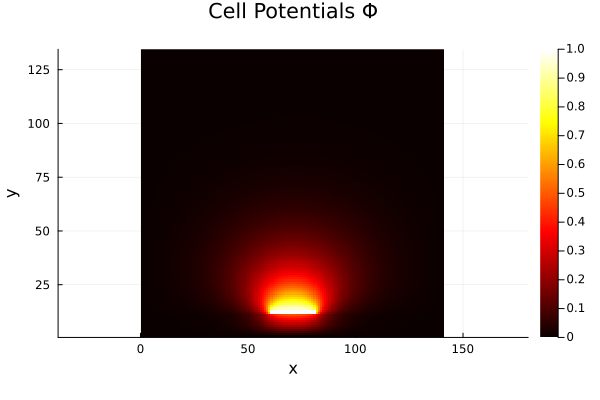

In [28]:
# Φ is already a Matrix{Float64}
heatmap(
    reverse(Φ_C, dims=1),
    clim = (0, 1),
    aspect_ratio = 1,
    color =  :hot,
    colorbar = true,
    xlabel = "x",
    ylabel = "y",
    title = "Cell Potentials Φ"
)


In [29]:
"""
    epsilon_eff(W, h, ϵr)

Effective dielectric constant for a microstrip line.
Eq. (5.51)
"""
function epsilon_eff(W::T, h::T, ϵr::T) where {T<:AbstractFloat}
    Wh = W / h

    if Wh ≤ 1
        return (ϵr + 1)/2 +
               (ϵr - 1)/2 *
               ((1 + 12h/W)^(-1/2) + 0.04*(1 - Wh)^2)
    else
        return (ϵr + 1)/2 +
               (ϵr - 1)/2 *
               (1 + 12h/W)^(-1/2)
    end
end
"""
    Z0_microstrip(W, h, ϵr)

Characteristic impedance of a microstrip line (ohms).
Uses Eq. (5.50) with ε_eff from Eq. (5.51).
"""
function Z0_microstrip(W::T, h::T, ϵr::T) where {T<:AbstractFloat}
    ϵeff = epsilon_eff(W, h, ϵr)
    Wh = W / h

    if Wh ≤ 1
        return (60 / sqrt(ϵeff)) * log(8h/W + 0.25*Wh)
    else
        return (120π / sqrt(ϵeff)) /
               (Wh + 1.393 + 0.667*log(Wh + 1.444))
    end
end

Z0_microstrip(0.002, 0.001, 9.6)


33.96439884257163